### Submission 1: Price a European Up-and-out Call Option

In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt
%matplotlib inline

We initialize most variables as given by the question. We assume the counterparty firm's value is at 200, as this is above the counterparty's debt due in one year. Also, we calculate the default-free value of our option to be 6.60, so we select a firm value not too distant such that the CVA value we calculate is not negligible. For example, if we chose counterparty firm value as 1,000, the CVA would be 0.000.

In [25]:
### Initialize problem parameters
# option maturity
T = 1
# up-and-out barrier
L = 150
# current share price
S0 = 100
# strike price, at-the-money
K = 100
# risk-free rate
risk_free = .08
# volatility
sigma = .3

# counterparty firm current value
v_0 = 200 # Our assumption 
# volatility for the counterparty's firm
sigma_firm = .25
# counterparty's debt, due in one year 
debt = 175
# correlation
corr = .2
# recovery rate
recovery_rate = 0.25

########
corr_matrix = np.array([[1, corr], [corr, 1]])
sample_sizes = range(1000, 50001, 1000)

## 1. Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.

We use a Cholesky decomposition to generate the correlated price paths

In [26]:
def share_path(S_0, risk_free_rate, sigma, Z, dT):
    return S_0*np.exp(np.cumsum((risk_free_rate-sigma**2/2)*dT + sigma*np.sqrt(dT)*Z,1))


def generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 10, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    share_price_path = pd.DataFrame(share_path(S0, risk_free, sigma, Z=corr_norm_matrix[:,0,], dT=1/timesteps))
    share_price_path = share_price_path.transpose()

    firm_price_path = pd.DataFrame(share_path(v_0, risk_free, sigma_firm, Z=corr_norm_matrix[:,1,], dT=1/timesteps))
    firm_price_path = firm_price_path.transpose()

    return [share_price_path,firm_price_path]  

To double check that the stock prices and firm values monthly returns are correlated, we check them as follows, generating 20 different price paths with 10,000 timesteps.

In [27]:
#Testing share and firm price correlation
sample_size = 20
test = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size, timesteps = 10000)

share_ret = np.log(test[0])

for i in range(sample_size):
    test[0]['sharelog'] = np.log(test[0][i])
    test[1]['firmlog'] = np.log(test[1][i])
    pearson, p_value = stats.pearsonr(test[0]['sharelog'].diff().dropna(), test[1]['firmlog'].diff().dropna())
    print("Pearson correlation coefficient : {:.3f}, Two-tailed p-value {:.3f}".format(pearson, p_value))

Pearson correlation coefficient : 0.195, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.206, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.184, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.185, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.217, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.204, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.212, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.215, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.196, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.182, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.213, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.182, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.205, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.207, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.200, Two-tailed p-value 0.000
Pearson co

Let's try to simulate the share price with a small number of sample paths and visualize them over the course of 12 months

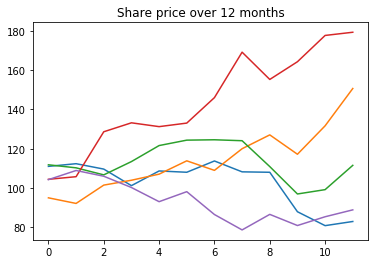

In [28]:
share_and_firm_price_12_months = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 5, timesteps = 12)
share_price_12_months = share_and_firm_price_12_months[0]
share_price_12_months.plot(title='Share price over 12 months', legend=False);

We can do the same thing to simulate counterparty firm's value

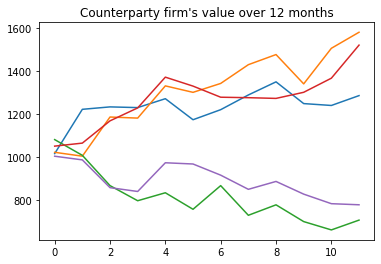

In [29]:

firm_value_12_months = share_and_firm_price_12_months[1]
firm_value_12_months.plot(title="Counterparty firm's value over 12 months", legend=False);

In fact, we can also simulate the dynamic with finer resolution.

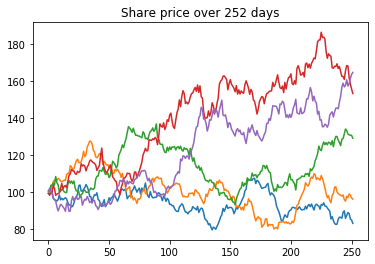

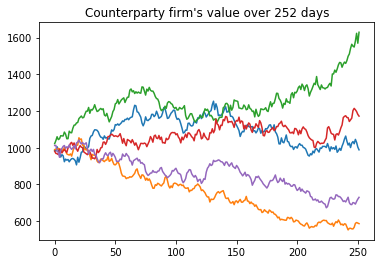

In [30]:
share_and_firm_price_252_days = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 5, timesteps = 252)
share_price_252_days = share_and_firm_price_252_days[0]
firm_price_252_days = share_and_firm_price_252_days[1]
share_price_252_days.plot(title='Share price over 252 days', legend=False)
firm_price_252_days.plot(title="Counterparty firm's value over 252 days", legend=False);

Let's visualize when the stopped process is appied

In [31]:
def stop(s, cond):
    ret = s.copy()
    r = ret[cond]
    if len(r) > 0:
        print(r)
        ret[r.idxmin():] = 0
    return ret

11    150.64871
Name: 1, dtype: float64
7     169.157458
8     155.262840
9     164.290122
10    177.683091
11    179.312349
Name: 3, dtype: float64


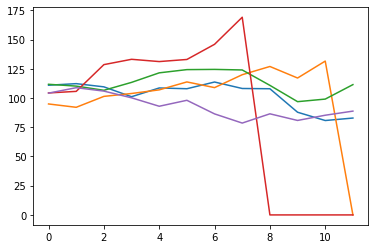

In [32]:
share_price_12_months.apply(lambda s: stop(s, s>L), axis=0).plot(legend=False);

We then define a function to calculate the payoff for the up-and-out call option.

In [33]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

payoff(share_price_12_months, K, L)

array([ 0.        ,  0.        , 11.49807165,  0.        ,  0.        ])

We now create the share and firm price paths for sample sizes 1000, 2000, ...., 50000, as required for part 1 of the assignment.

In [34]:
share_price_paths = {}
firm_val_paths = {}

sample_sizes = range(1000, 50001, 1000)

for sample_size in sample_sizes:
    share_val, firm_val = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = sample_size, timesteps = 12)
     
    share_price_paths[sample_size] = share_val
    firm_val_paths[sample_size] = firm_val

We now plot the share and firm price paths for sample size of 1000.

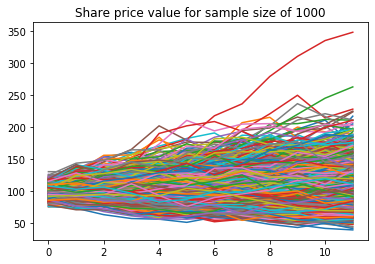

In [35]:
share_price_paths[1000].plot(title="Share price value for sample size of 1000", legend=False);

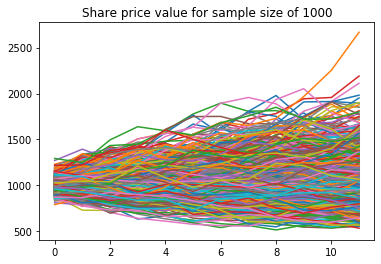

In [36]:
firm_val_paths[1000].plot(title="Share price value for sample size of 1000", legend=False);

## 2. Determine the Monte Carlo estimates of the both the default-free value of the option and the Credit Valuation Adjustment

To calculate Monte Carlo estimate of the default-free option value, we calculate the average payoff of the 1000s of sample price paths, to estimate the price of the option

In [37]:
# Estimate the default-free value of the option:
option_estimate = []
option_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs
    option_estimate.append(option_price.mean())
    option_std.append(option_price.std()/np.sqrt(sample_size))


Prices of default-free option at various sample sizes:

In [38]:
for i in range(len(option_estimate)):
    print("sample size: {}, Option value: {:.3f}".format((i+1)*1000,option_estimate[i]))

sample size: 1000, Option value: 6.962
sample size: 2000, Option value: 6.589
sample size: 3000, Option value: 6.301
sample size: 4000, Option value: 6.644
sample size: 5000, Option value: 6.703
sample size: 6000, Option value: 6.771
sample size: 7000, Option value: 6.794
sample size: 8000, Option value: 6.934
sample size: 9000, Option value: 6.652
sample size: 10000, Option value: 6.394
sample size: 11000, Option value: 6.627
sample size: 12000, Option value: 6.584
sample size: 13000, Option value: 6.643
sample size: 14000, Option value: 6.576
sample size: 15000, Option value: 6.727
sample size: 16000, Option value: 6.878
sample size: 17000, Option value: 6.710
sample size: 18000, Option value: 6.791
sample size: 19000, Option value: 6.686
sample size: 20000, Option value: 6.772
sample size: 21000, Option value: 6.660
sample size: 22000, Option value: 6.640
sample size: 23000, Option value: 6.712
sample size: 24000, Option value: 6.583
sample size: 25000, Option value: 6.699
sample si

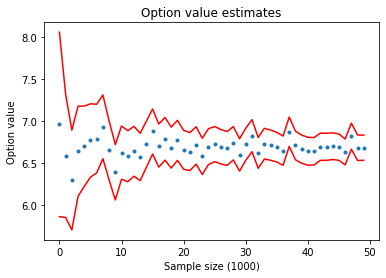

In [39]:
plt.plot(option_estimate, '.')
plt.plot(option_estimate + 3 * np.array(option_std), 'r')
plt.plot(option_estimate - 3 * np.array(option_std), 'r')
plt.title("Option value estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()

### CVA Adjustment

To calculate Monte Carlo estimate of the credit value adjustment, we calculate the average loss of the 1000s of sample price paths, which happens when we both see a gain in the option with hold and when the counterparty firm value is less than its debt.

As per notes, we assume that default can only occur at time T, and firm defaults if the firm value is below firm debt amount

In [40]:
def terminal_value(S_0, risk_free_rate, sigma, Z, T): #applies to both firm and stock
    return S_0 * np.exp((risk_free_rate - sigma**2/2) * T + sigma * np.sqrt(T) * Z)

In [41]:
cva_estimate = []
cva_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    cva_estimate.append(amount_lost.mean())
    cva_std.append(amount_lost.std()/np.sqrt(sample_size))
    

Credit value adjustment at various sample sizes:

In [42]:
for i in range(len(cva_estimate)):
    print("Sample size: {}, CVA: {:.3f}".format((i+1)*1000,cva_estimate[i]))

Sample size: 1000, CVA: 0.000
Sample size: 2000, CVA: 0.000
Sample size: 3000, CVA: 0.000
Sample size: 4000, CVA: 0.000
Sample size: 5000, CVA: 0.000
Sample size: 6000, CVA: 0.000
Sample size: 7000, CVA: 0.000
Sample size: 8000, CVA: 0.000
Sample size: 9000, CVA: 0.000
Sample size: 10000, CVA: 0.000
Sample size: 11000, CVA: 0.000
Sample size: 12000, CVA: 0.000
Sample size: 13000, CVA: 0.000
Sample size: 14000, CVA: 0.000
Sample size: 15000, CVA: 0.000
Sample size: 16000, CVA: 0.000
Sample size: 17000, CVA: 0.000
Sample size: 18000, CVA: 0.000
Sample size: 19000, CVA: 0.000
Sample size: 20000, CVA: 0.000
Sample size: 21000, CVA: 0.000
Sample size: 22000, CVA: 0.000
Sample size: 23000, CVA: 0.000
Sample size: 24000, CVA: 0.000
Sample size: 25000, CVA: 0.000
Sample size: 26000, CVA: 0.000
Sample size: 27000, CVA: 0.000
Sample size: 28000, CVA: 0.000
Sample size: 29000, CVA: 0.000
Sample size: 30000, CVA: 0.000
Sample size: 31000, CVA: 0.000
Sample size: 32000, CVA: 0.000
Sample size: 3300

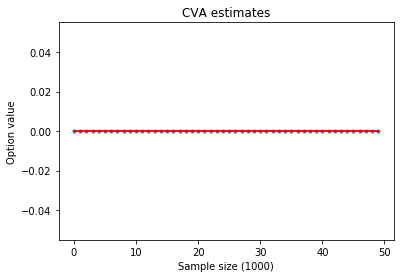

In [43]:
plt.plot(cva_estimate, '.')
plt.plot(cva_estimate + 3 * np.array(cva_std), 'r')
plt.plot(cva_estimate - 3 * np.array(cva_std), 'r')
plt.title("CVA estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()

## 3. Calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA.

In [44]:
option_cva_adjusted_prices = []
option_cva_adjusted_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs

    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    
    option_cva_price = option_price - amount_lost
    
    option_cva_adjusted_prices.append(option_cva_price.mean())
    option_cva_adjusted_std.append(option_cva_price.std()/np.sqrt(sample_size))



Credit value adjustment at various sample sizes:

In [45]:
for i in range(len(option_cva_adjusted_prices)):
    print("Sample size: {}, CVA-adjusted option value: {:.3f}".format((i+1)*1000,option_cva_adjusted_prices[i]))

Sample size: 1000, CVA-adjusted option value: 6.962
Sample size: 2000, CVA-adjusted option value: 6.589
Sample size: 3000, CVA-adjusted option value: 6.301
Sample size: 4000, CVA-adjusted option value: 6.644
Sample size: 5000, CVA-adjusted option value: 6.703
Sample size: 6000, CVA-adjusted option value: 6.771
Sample size: 7000, CVA-adjusted option value: 6.794
Sample size: 8000, CVA-adjusted option value: 6.934
Sample size: 9000, CVA-adjusted option value: 6.652
Sample size: 10000, CVA-adjusted option value: 6.394
Sample size: 11000, CVA-adjusted option value: 6.627
Sample size: 12000, CVA-adjusted option value: 6.584
Sample size: 13000, CVA-adjusted option value: 6.643
Sample size: 14000, CVA-adjusted option value: 6.576
Sample size: 15000, CVA-adjusted option value: 6.727
Sample size: 16000, CVA-adjusted option value: 6.878
Sample size: 17000, CVA-adjusted option value: 6.710
Sample size: 18000, CVA-adjusted option value: 6.791
Sample size: 19000, CVA-adjusted option value: 6.686
Sa

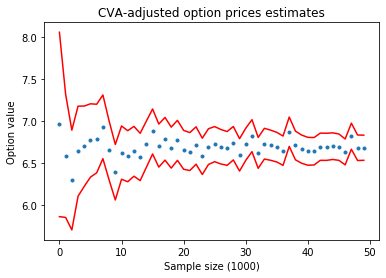

In [46]:
plt.plot(option_cva_adjusted_prices, '.')
plt.plot(option_cva_adjusted_prices + 3 * np.array(option_cva_adjusted_std), 'r')
plt.plot(option_cva_adjusted_prices - 3 * np.array(option_cva_adjusted_std), 'r')
plt.title("CVA-adjusted option prices estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()